# Compare methods with optimize parameters in ref_case

In [31]:
import xarray as xr
import pandas as pd
import numpy as np

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import pynsitu as pyn

from lib import KEYS, raw_dir, images_dir

import os
from glob import glob

import synthetic_traj as st

from synthetic_traj import (
    synthetic_traj,
    noise_irregular_sampling,
    ref_case,
    typical_case,
)
import lib

___________
# Reference case + centered_diff

In [2]:
N = 100
acc_cut = 1e-3
position_noise = 20
ntype = "white_noise"
offset_type = "svp_scripps_10"
dt_smooth = "30min"
true_key = "True_" + dt_smooth
spectral_diff = False
ref_case["spectral_diff"] = spectral_diff
print(ref_case)

{'T': 5, 'U_low': 0.3, 'U_ni': 0.2, 'U_2': 0, 'U_1': 0, 'tau_eta': 0.1, 'n_layers': 5, 'spectral_diff': False}


In [3]:
DF = dict()

# TRUE
t = (
    50,
    "1min",
)  # use it instead of (50, 1/24/60 because otherwise not regularly sampled
dst = synthetic_traj(t, N, **ref_case)  # u,v, ax, ay computed
dft = st.dataset2dataframe(dst).rename(columns={"draw": "id"})
DF["True_1min"] = dft

# OBSERVED
dso = noise_irregular_sampling(
    dst, t, position_noise, ntype=ntype, offset_type=offset_type, istart=6097
)
dfo = st.dataset2dataframe(dso).rename(columns={"draw": "id"})
dfo = dfo.groupby("id").apply(pyn.geo.compute_dt, time="index")


DF["Observed"] = dfo

# Interpolated True
dsti = dst.sel(time=pd.date_range(dfo.index.min(), dfo.index.max(), freq=dt_smooth))
dsti["dt"] = dsti.time.diff("time") / pd.Timedelta("1s")
st.add_position_noise(
    dsti, dsti.time, position_noise, ntype=ntype, inplace=True
)  # adding noise
dsti["u_noise"] = dsti.x_noise.differentiate("time", datetime_unit="s")
dsti["v_noise"] = dsti.y_noise.differentiate("time", datetime_unit="s")
dfti = st.dataset2dataframe(dsti).rename(columns={"draw": "id"})
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_velocities,
    time="index",
    distance="xy",
    names=("u", "v", "U"),
    fill_startend=True,
    centered=True,
    keep_dt=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x", "y"),
    names=("ax", "ay", "Axy"),
    keep_dt=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x_noise", "y_noise"),
    names=("ax_noise", "ay_noise", "Axy_noise"),
    keep_dt=True,
)
dsti = dfti.reset_index().set_index(["time", "id"]).to_xarray()

DF["True_" + dt_smooth] = dfti

centred diff
centred diff
-13394.13809599266
6097


In [5]:
parameters_var = dict(
    acc_cut=1,
    position_error=60,
    acceleration_amplitude=4e-6,
    acceleration_T=0.05 * 86400,
    time_chunk=2,
    acc_cut_key=("ax", "ay", "Axy"),
)
parameters_lowess = dict(degree=2, iteration=3, T_low_pass = 20, cutoff_low_pass = 13)
parameters_spydell = dict(nb_pt_mean=5, acc_cut=1)


dfl = pyn.drifters.smooth_all(
    dfo,
    "lowess",
    dt_smooth,
    parameters=parameters_lowess,
    spectral_diff=spectral_diff,
    geo=False,
)
dfv = pyn.drifters.smooth_all(
    dfo,
    "variational",
    dt_smooth,
    parameters=parameters_var,
    spectral_diff=spectral_diff,
    geo=False,
)
dfs = pyn.drifters.smooth_all(
    dfo,
    "spydell",
    dt_smooth,
    parameters=parameters_spydell,
    spectral_diff=spectral_diff,
    geo=False,
)

DF["LOWESS"] = dfl
DF["Variational"] = dfv
DF["Empirical"] = dfs
color = {
    "True_1min": "grey",
    "Observed": "gold",
    "True_30min": "k",
    "LOWESS": "teal",
    "Variational": "salmon",
    "Empirical": "r",
}

LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd with 20pad
LOW-PASS : 13cpd wit

In [24]:
DF.keys()

dict_keys(['True_1min', 'Observed', 'True_30min', 'LOWESS', 'Variational', 'Empirical'])

In [17]:
linthresh = 5e-1
linscale = 0.3
color = {
    "True_1min": "grey",
    "Observed": "gold",
    "True_30min": "k",
    "LOWESS": "teal",
    "Variational": "salmon",
    "Empirical": "r",
}
zorder = {
    "True_1min": 0,
    "True_30min": 0,
    "LOWESS": 1,
    "Variational": 1,
    "Empirical": 1,
}

In [42]:
def DSE2dse(DSE):
    ds = xr.concat(
        [d[["x_y", "u_v", "ax_ay"]] for d in DSE.values()], dim=list(DSE.keys())
    )
    return ds.rename({"concat_dim": "Trajectory"})


def find_fmin_fmax(ds, pourcentage):
    ds = ds.where(ds < pourcentage / 100, drop=True)
    return float(ds.isel(frequency=0).frequency), float(ds.isel(frequency=-1).frequency)

# spectra
DF0 = DF.copy()
DF0.pop("True_1min")
DSE = st.spectrum_DF(DF0, nperseg="20D", detrend="linear")
dse = DSE2dse(DSE)


# diff spectra
DF_diff = st.build_DF_diff(DF0, true_key="True_30min")
DSE_d = st.spectrum_DF(DF_diff, nperseg="20D", detrend="linear")
dse_d = DSE2dse(DSE_d)

#diff spectra/spectra
DSE_dn = DSE_d.copy()
for l in DSE_d:
    DSE_dn[l] = DSE_d[l] / DSE["True_30min"]

#Fu = {l: find_fmin_fmax(DSE_dn[l].u_v.mean("id"), 10) for l in DSE_dn}
#Fa = {l: find_fmin_fmax(DSE_dn[l].ax_ay.mean("id"), 10) for l in DSE_dn}

True_30min
LOWESS
Variational
Empirical
Observed has not the same time index
LOWESS
Variational
Empirical


In [27]:
Fa

{'LOWESS': (-5.6000000000000005, 4.7),
 'Variational': (-3.1, 1.9000000000000001),
 'Empirical': (-2.5, 1.25)}

In [28]:
Fu

{'LOWESS': (-6.0, 4.800000000000001),
 'Variational': (-3.1, 1.9000000000000001),
 'Empirical': (-2.6, 1.25)}

___________
# $PSD_{\alpha}$

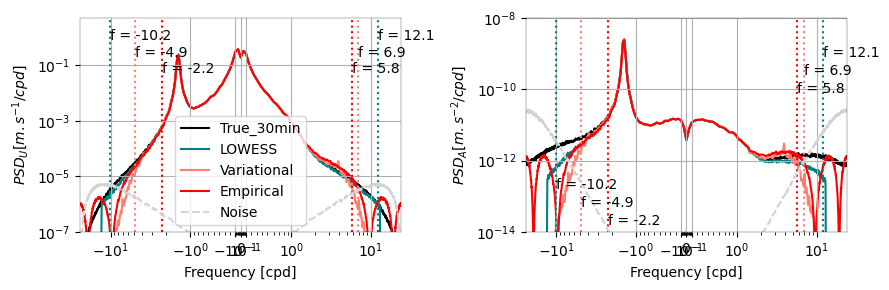

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
ax = axs[0]
i = 0
for l in DSE.keys():
    DSE[l].u_v.mean("id").plot(
        ax=ax,
        label=l,
        color=color[l],
        zorder=zorder[l],
    )
    if l != "True_30min":
        ax.axvline(Fu[l][0], color=color[l], ls=":")
        ax.axvline(Fu[l][1], color=color[l], ls=":")
        ax.annotate(f"f = {round(Fu[l][0], 1)}", (Fu[l][0], 8e-1 / 10**i))
        ax.annotate(f"f = {round(Fu[l][1], 1)}", (Fu[l][1], 8e-1 / 10**i))
        i += 0.6
DSE["True_30min"].u_noise_v_noise.mean("id").plot(
    ax=ax, color="lightgrey", ls="--", label="Noise"
)

ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
ax.set_ylim(1e-7, 5e0)
ax.set_ylabel(r"$PSD_{U} [m.s^{-1}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.legend()
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))

ax = axs[1]
for l in DSE.keys():
    DSE[l].ax_ay.mean("id").plot(
        ax=ax,
        label=l,
        color=color[l],
        zorder=zorder[l],
    )
    if l != "True_30min":
        ax.axvline(Fa[l][0], color=color[l], ls=":")
        ax.axvline(Fa[l][1], color=color[l], ls=":")
        ax.annotate(f"f = {round(Fa[l][0], 1)}", (Fa[l][0], 1e-11 / 10**i))
        ax.annotate(f"f = {round(Fa[l][1], 1)}", (Fa[l][1], 5e-8 / 10**i))
        i += 0.5
DSE["True_30min"].ax_noise_ay_noise.mean("id").plot(
    ax=ax, color="lightgrey", ls="--", label="Noise"
)
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
ax.set_ylim(1e-14, 1e-8)
ax.set_ylabel(r"$PSD_{A} [m.s^{-2}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))
# ax.legend()
fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_spectra.png"), dpi=200, bbox_inches="tight"
)

________
# $PSD_{\alpha - \alpha_t}$

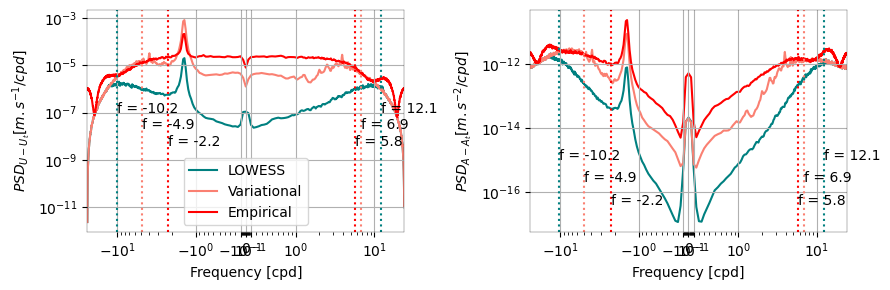

In [186]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
ax = axs[0]
# DSE_d.pop('nb_pt_mean =9')
i = 0
for l in DSE_d.keys():
    DSE_d[l].u_v.mean("id").plot(ax=ax, color=color[l], zorder=zorder[l], label=l)
    ax.axvline(Fu[l][0], color=color[l], ls=":")
    ax.axvline(Fu[l][1], color=color[l], ls=":")
    ax.annotate(f"f = {round(Fu[l][0], 1)}", (Fu[l][0], 1e-7 / 10**i))
    ax.annotate(f"f = {round(Fu[l][1], 1)}", (Fu[l][1], 1e-7 / 10**i))
    i += 0.7
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(1e-7, 5e0)
ax.set_ylabel(r"$PSD_{U-U_t} [m.s^{-1}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))
ax.legend()

ax = axs[1]
i = 0
for l in DSE_d.keys():
    DSE_d[l].ax_ay.mean("id").plot(ax=ax, color=color[l], zorder=zorder[l], label=l)
    ax.axvline(Fa[l][0], color=color[l], ls=":")
    ax.axvline(Fa[l][1], color=color[l], ls=":")
    ax.annotate(f"f = {round(Fa[l][0], 1)}", (Fa[l][0], 1e-15 / 10**i))
    ax.annotate(f"f = {round(Fa[l][1], 1)}", (Fa[l][1], 1e-15 / 10**i))
    i += 0.7
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(5e-13, 1e-5)
ax.set_ylabel(r"$PSD_{A-A_t} [m.s^{-2}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))

fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_diffspectra.png"), dpi=200, bbox_inches="tight"
)

________
## $PSD_{\alpha-\alpha_t}/PSD_{\alpha}$

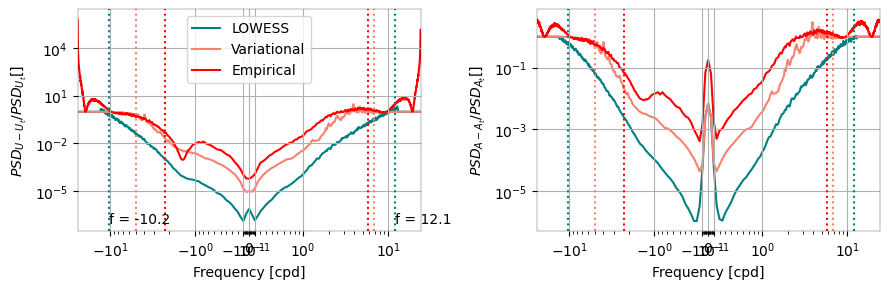

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
ax = axs[0]
# DSE_d.pop('nb_pt_mean =9')
i = 0
for l in DSE_dn.keys():
    DSE_dn[l].u_v.mean("id").plot(ax=ax, color=color[l], zorder=zorder[l], label=l)
    ax.axvline(Fu[l][0], color=color[l], ls=":")
    ax.axvline(Fu[l][1], color=color[l], ls=":")
    ax.annotate(f"f = {round(Fu[l][0], 1)}", (Fu[l][0], 1e-7 / 10**i))
    ax.annotate(f"f = {round(Fu[l][1], 1)}", (Fu[l][1], 1e-7 / 10**i))
    i += 0.7
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(1e-7, 5e0)
ax.set_ylabel(r"$PSD_{U-U_t}/PSD_{U_t}[]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))
ax.legend()

ax = axs[1]
i = 0
for l in DSE_dn.keys():
    DSE_dn[l].ax_ay.mean("id").plot(ax=ax, color=color[l], zorder=zorder[l], label=l)
    ax.axvline(Fa[l][0], color=color[l], ls=":")
    ax.axvline(Fa[l][1], color=color[l], ls=":")
    ax.annotate(f"f = {round(Fa[l][0], 1)}", (Fa[l][0], 1e-16 / 10**i))
    ax.annotate(f"f = {round(Fa[l][1], 1)}", (Fa[l][1], 1e-16 / 10**i))
    i += 0.7
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(5e-13, 1e-5)
ax.set_ylabel(r"$PSD_{A-A_t}/PSD_{A_t} []$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))

fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_diffspectra.png"), dpi=200, bbox_inches="tight"
)

_______
# Error-normalized cumulative spectral error
$$
ENCSE_{U,A}(f) [\%] = \left\{
    \begin{array}{ll}
        \langle -\frac{\int_0^{f} PSD_{U-U_t,A-A_t}(f') df' }{\sigma^2_{U-U_t,A-A_t}}\rangle_{id}\times 100 \text{ if f<0}\\
        \langle\frac{\int_0^{f} PSD_{U-U_t,A-A_t}(f') df' }{\sigma^2_{U-U_t,A-A_t}}\rangle_{id} \times 100 \text{ if f>0}
    \end{array}
    \right.
$$

In [123]:
dsed_n, dsed_p = st.negpos_spectra(dse_d)
dsd_norm = dse_d.integrate('frequency')
dn = dsed_n.cumulative_integrate('frequency')
dp = dsed_p.cumulative_integrate('frequency')
dn['frequency']=-dn['frequency']
encse = ((xr.concat([dn, dp], dim='frequency').sortby('frequency'))/dsd_norm).mean('id')*100

In [124]:
encse

<xarray.Dataset>
Dimensions:     (frequency: 961, Trajectory: 3)
Coordinates:
  * frequency   (frequency) float64 -24.0 -23.95 -23.9 ... 23.85 23.9 23.95
  * Trajectory  (Trajectory) object 'LOWESS' 'Variational' 'Empirical'
Data variables:
    x_y         (Trajectory, frequency) float64 82.41 82.41 ... 45.69 45.69
    u_v         (Trajectory, frequency) float64 60.65 60.65 ... 41.07 41.08
    ax_ay       (Trajectory, frequency) float64 58.19 58.09 ... 40.22 40.34

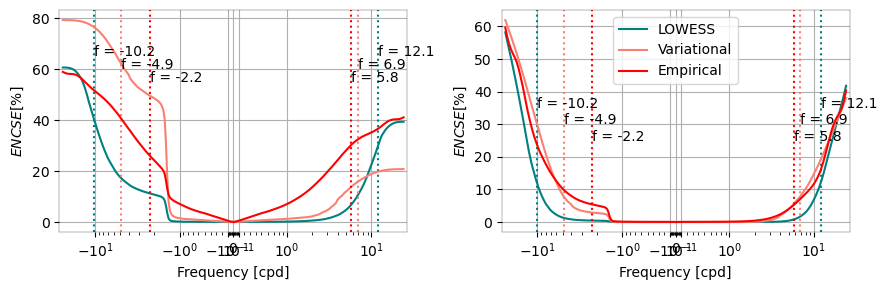

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
i = 0
j = 0
for l in ds.Trajectory.values:
    encse.sel(Trajectory=l).u_v.plot(ax=axs[0], color=color[l], label=l)
    axs[0].axvline(Fu[l][0], color=color[l], ls=":")
    axs[0].axvline(Fu[l][1], color=color[l], ls=":")
    axs[0].annotate(f"f = {round(Fu[l][0], 1)}", (Fu[l][0], 65 - i))
    axs[0].annotate(f"f = {round(Fu[l][1], 1)}", (Fu[l][1], 65- i))
    axs[0].set_ylabel(r"$ ENCSE [\%]$")
    encse.sel(Trajectory=l).ax_ay.plot(ax=axs[1], color=color[l], label=l)
    axs[1].axvline(Fa[l][0], color=color[l], ls=":")
    axs[1].axvline(Fa[l][1], color=color[l], ls=":")
    axs[1].annotate(f"f = {round(Fa[l][0], 1)}", (Fa[l][0], 35 - j))
    axs[1].annotate(f"f = {round(Fa[l][1], 1)}", (Fa[l][1], 35 - j))
    axs[1].set_ylabel(r"$ ENCSE [\%]$")
    axs[1].legend()
    i += 5
    j += 5
for a in axs:
    a.grid()
    a.set_title("")
    a.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
    a.set_xlabel("Frequency [cpd]")
    a.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))
    # a.axhline(0.9,color='k', ls='--')

fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_encse.png"), dpi=200, bbox_inches="tight"
)

_______
# Maximum frequencies SNCSE = limite%

In [173]:
limiteu = 0.01
limitea=1

def find_fmin_fmax(ds, pourcentage):
    ds = ds.where(ds < pourcentage, drop=True)
    return float(ds.isel(frequency=0).frequency), float(ds.isel(frequency=-1).frequency)
#Fu = {l: find_fmin_fmax(sncse.sel(Trajectory = l).u_v, limiteu) for l in sncse.Trajectory.values}
Fa = {l: find_fmin_fmax(sncse.sel(Trajectory = l).ax_ay, limitea) for l in sncse.Trajectory.values}
Fu=Fa

In [174]:
Fu

{'LOWESS': (-10.200000000000001, 12.100000000000001),
 'Variational': (-4.9, 6.8500000000000005),
 'Empirical': (-2.25, 5.75)}

_______
# Signal-normalized cumulative spectral error
$$
    SNCSE_{U,A}(f) [\%] = \left\{
    \begin{array}{ll}
        \langle -\frac{\int_0^{f} PSD_{U-U_t,A-A_t}(f') df' }{\sigma^2_{U_t,A_t}}\rangle_{id}\times 100 \text{ if f<0}\\
        \langle \frac{\int_0^{f} PSD_{U-U_t,A-A_t}(f') df' }{\sigma^2_{U_t,A_t}}\rangle_{id}\times 100 \text{ if f>0}
    \end{array}
    \right.
$$

In [175]:
dsed_n, dsed_p = st.negpos_spectra(dse_d)
ds_norm = dse.integrate('frequency')
dn = dsed_n.cumulative_integrate('frequency')
dp = dsed_p.cumulative_integrate('frequency')
dn['frequency']=-dn['frequency']
sncse = ((xr.concat([dn, dp], dim='frequency').sortby('frequency'))/ds_norm).mean('id')*100

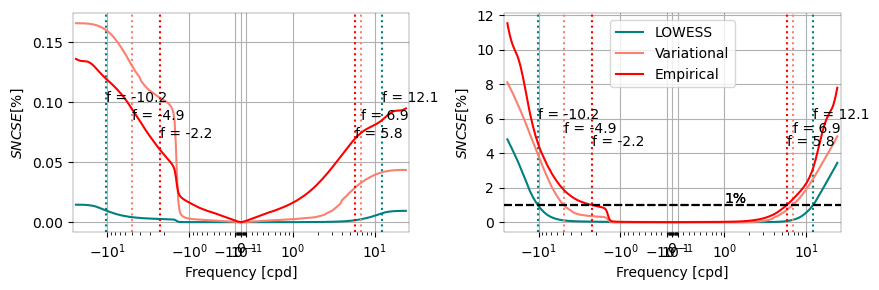

In [176]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
i = 0
j = 0
for l in ds.Trajectory.values:
    sncse.sel(Trajectory=l).u_v.plot(ax=axs[0], color=color[l], label=l)
    axs[0].axvline(Fa[l][0], color=color[l], ls=":")
    axs[0].axvline(Fa[l][1], color=color[l], ls=":")
    axs[0].annotate(f"f = {round(Fa[l][0], 1)}", (Fa[l][0], 0.1 - i))
    axs[0].annotate(f"f = {round(Fa[l][1], 1)}", (Fa[l][1], 0.1- i))
    axs[0].set_ylabel(r"$ SNCSE [\%]$")
    #axs[0].axhline(0.01, color='k', ls='--')
    sncse.sel(Trajectory=l).ax_ay.plot(ax=axs[1], color=color[l], label=l)
    axs[1].axvline(Fa[l][0], color=color[l], ls=":")
    axs[1].axvline(Fa[l][1], color=color[l], ls=":")
    axs[1].annotate(f"f = {round(Fa[l][0], 1)}", (Fa[l][0], 6 - j))
    axs[1].annotate(f"f = {round(Fa[l][1], 1)}", (Fa[l][1], 6 - j))
    axs[1].set_ylabel(r"$ SNCSE [\%]$")
    axs[1].legend()
    axs[1].axhline(1, color='k', ls='--')
    axs[1].annotate('1%', (1,1.1))
    i += 0.015
    j += 0.8
for a in axs:
    a.grid()
    a.set_title("")
    a.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
    a.set_xlabel("Frequency [cpd]")
    a.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))
    # a.axhline(0.9,color='k', ls='--')

fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_sncse.png"), dpi=200, bbox_inches="tight"
)

__________
# Parseval

In [77]:
dse_d.integrate("frequency").mean("id")

<xarray.Dataset>
Dimensions:     (Trajectory: 3)
Coordinates:
  * Trajectory  (Trajectory) object 'LOWESS' 'Variational' 'Empirical'
Data variables:
    x_y         (Trajectory) float64 1.709e+03 9.062e+04 1.606e+06
    u_v         (Trajectory) float64 4.005e-05 0.000285 0.0003147
    ax_ay       (Trajectory) float64 4.218e-11 5.132e-11 7.921e-11

In [78]:
dsmsds

<xarray.Dataset>
Dimensions:     (Trajectory: 3)
Coordinates:
  * Trajectory  (Trajectory) object 'LOWESS' 'Variational' 'Empirical'
Data variables:
    x_y         (Trajectory) float64 6.981e+03 7.582e+04 1.901e+06
    u_v         (Trajectory) float64 4.472e-05 0.0002867 0.0003229
    ax_ay       (Trajectory) float64 1.426e-10 5.112e-11 1.798e-10
    x           (Trajectory) float64 3.206e+03 3.805e+04 6.545e+05
    y           (Trajectory) float64 3.775e+03 3.777e+04 1.246e+06
    u           (Trajectory) float64 2.286e-05 0.0001475 0.0001638
    v           (Trajectory) float64 2.186e-05 0.0001392 0.0001591
    ax          (Trajectory) float64 6.6e-11 2.596e-11 8.417e-11
    ay          (Trajectory) float64 7.662e-11 2.516e-11 9.562e-11

In [79]:
D = []
for l in DF_diff_ms:
    D.append(DF_diff_ms[l].to_xarray())
dsmsds = (
    xr.concat(D, dim=list(DF_diff_ms.keys()))
    .rename({"concat_dim": "Trajectory"})
    .mean("id")
)

In [80]:
ds_ = (dsmsds - dse_d.integrate("frequency").mean("id")) / dsmsds
ds_

<xarray.Dataset>
Dimensions:     (Trajectory: 3)
Coordinates:
  * Trajectory  (Trajectory) object 'LOWESS' 'Variational' 'Empirical'
Data variables:
    x_y         (Trajectory) float64 0.7553 -0.1952 0.155
    u_v         (Trajectory) float64 0.1044 0.005957 0.0255
    ax_ay       (Trajectory) float64 0.7043 -0.003916 0.5594

In [64]:
ds_ = (dsmsds - dse_d.integrate("frequency").mean("id")) / dsmsds
ds_

<xarray.Dataset>
Dimensions:     (Trajectory: 3)
Coordinates:
  * Trajectory  (Trajectory) object 'LOWESS' 'Variational' 'Empirical'
Data variables:
    x_y         (Trajectory) float64 0.7553 -0.1952 0.155
    u_v         (Trajectory) float64 0.1044 0.005957 0.0255
    ax_ay       (Trajectory) float64 0.7043 -0.003916 0.5594